In [1]:
import patato as pat
import glob

import numpy as np
import patato as pat
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.auto import tqdm

from shapely.geometry import Polygon, MultiPolygon

from palettable.cartocolors.qualitative import Pastel_3

In [2]:
b6 = glob.glob("../data/mice/b6/*.hdf5")
al = glob.glob("../data/mice/albino/*.hdf5")

b6 = [pat.PAData.from_hdf5(x) for x in b6]
al = [pat.PAData.from_hdf5(x) for x in al]

In [3]:
mouse_identities = pd.read_excel("Black 6 Mice Images.ods")
mouse_identities = mouse_identities.set_index("Scan Name")

In [4]:
def get_intersection_mask(recon, roi1, roi_mask):
    roi_intersect = pat.ROI(
        roi1.get_polygon() & roi_mask.get_polygon(),
        roi1.z,
        roi1.run,
        roi1.repetition,
        roi1.roi_class,
        roi1.position,
        True,
        roi1.ax0_index,
    )
    # display(roi_intersect.points)
    return roi_intersect.to_mask_slice(recon)[0]


def get_rim_core_data(pa):
    rois = pa.get_rois(rim_core_distance=0.001, get_rim_cores=["body_"])
    roi_core = rois["body.core_", "0"]
    roi_rim = rois["body.rim_", "0"]

    roi_mask = rois["body_", "1"]

    rec = pa.get_scan_reconstructions()["Reference Backprojection", "0"]
    unmixed = pa.get_scan_unmixed()["Reference Backprojection", "0"]

    print(unmixed.ax_1_labels)

    core_mask = get_intersection_mask(rec, roi_core, roi_mask)
    rim_mask = get_intersection_mask(rec, roi_rim, roi_mask)

    core_mask_so2 = get_intersection_mask(unmixed, roi_core, roi_mask)
    rim_mask_so2 = get_intersection_mask(unmixed, roi_rim, roi_mask)

    rec_data = rec.raw_data
    # for i in range(rec_data.shape[0]):
    #     rec_data[i, :, np.any(rec_data[i] < 0, axis=0)] = np.nan

    # Filter out negative pixels for unmixing only:
    unmixed_data = unmixed.raw_data
    for i in range(unmixed_data.shape[0]):
        unmixed_data[i, :, np.any(unmixed_data[i] < 0, axis=0)] = np.nan

    return (
        rec_data.T[rim_mask.T].T,
        rec_data.T[core_mask.T].T,
        unmixed_data.T[rim_mask_so2.T].T,
        unmixed_data.T[core_mask_so2.T].T,
    )

In [5]:
measurements = []

  0%|          | 0/19 [00:00<?, ?it/s]

['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']


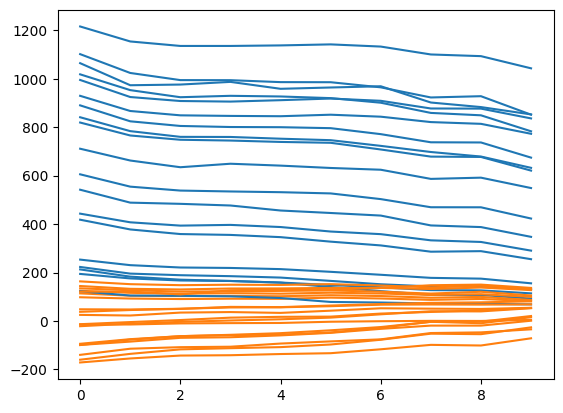

In [6]:
for x in tqdm(b6):
    if x.get_rois():
        rim_data, core_data, rim_so2, core_so2 = get_rim_core_data(x)
        plt.plot(np.nanmean(rim_data, axis=(0, 2)), c="C0")
        plt.plot(np.nanmean(core_data, axis=(0, 2)), c="C1")
        measurements.append(
            {
                "Wavelength": x.get_wavelengths(),
                "Rim Signal": np.nanmean(rim_data, axis=(0, 2)),
                "Core Signal": np.nanmean(core_data, axis=(0, 2)),
                "Mouse Type": "B6",
                "pigmentation": mouse_identities.loc[
                    x.get_scan_name(), "Heavy Pigmentation"
                ],
                "back pigmentation": mouse_identities.loc[
                    x.get_scan_name(), "Back Pigment"
                ],
                "front pigmentation": mouse_identities.loc[
                    x.get_scan_name(), "Front Pigment"
                ],
                "Rim Unmixed": np.nanmedian(rim_so2, axis=(0, 2)),
                "Core Unmixed": np.nanmedian(core_so2, axis=(0, 2)),
                "Scan Name": x.get_scan_name(),
            }
        )
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']
['Hb' 'HbO2']


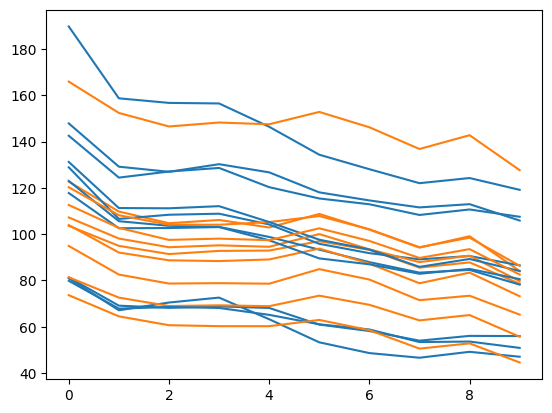

In [7]:
for x in tqdm(al):
    if x.get_rois():
        rim_data, core_data, rim_so2, core_so2 = get_rim_core_data(x)
        plt.plot(np.nanmean(rim_data, axis=(0, 2)), c="C0")
        plt.plot(np.nanmean(core_data, axis=(0, 2)), c="C1")
        measurements.append(
            {
                "Wavelength": x.get_wavelengths(),
                "Rim Signal": np.nanmean(rim_data, axis=(0, 2)),
                "Core Signal": np.nanmean(core_data, axis=(0, 2)),
                "Mouse Type": "Albino",
                "pigmentation": "No",
                "back pigmentation": "No",
                "front pigmentation": "No",
                "Rim Unmixed": np.nanmedian(rim_so2, axis=(0, 2)),
                "Core Unmixed": np.nanmedian(core_so2, axis=(0, 2)),
                "Scan Name": x.get_scan_name(),
            }
        )
plt.show()

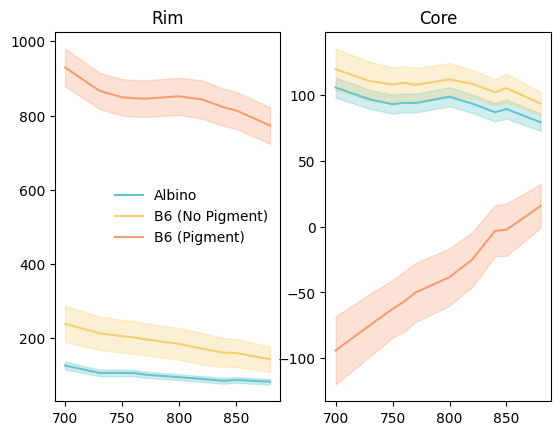

In [8]:
df = pd.DataFrame(measurements)

fig, (ax2, ax1) = plt.subplots(1, 2)

i = 0

for (mouse, pig), t in df.groupby(["Mouse Type", "pigmentation"]):
    label = mouse + (" " + pig if mouse == "B6" else "")
    label = label.replace("No", "(No Pigment)")
    label = label.replace("Yes", "(Pigment)")
    c = np.array(t["Core Signal"].tolist())
    m = np.nanmedian(c, axis=0)
    s = np.nanstd(c, axis=0) / np.sqrt(c.shape[0])
    l = ax1.plot(t["Wavelength"].iloc[0], m, label=label, c=Pastel_3.mpl_colors[i])
    ax1.fill_between(
        t["Wavelength"].iloc[0], m - s, m + s, alpha=0.3, color=Pastel_3.mpl_colors[i]
    )

    c = np.array(t["Rim Signal"].tolist())
    m = np.nanmedian(c, axis=0)
    s = np.nanstd(c, axis=0) / np.sqrt(c.shape[0])
    ax2.plot(t["Wavelength"].iloc[0], m, label=label, c=Pastel_3.mpl_colors[i])
    ax2.fill_between(
        t["Wavelength"].iloc[0], m - s, m + s, alpha=0.3, color=Pastel_3.mpl_colors[i]
    )
    i += 1
ax1.set_title("Core")
ax2.set_title("Rim")
# ax1.set_ylim((0, None))
# ax2.set_ylim((0, None))
ax2.legend(frameon=False)


plt.show()

In [9]:
df.to_pickle("intermediate results/skin_core_data.pd")